# Grid_search_best_topic_models_for_recipes_table

This notebook apply grid search to find the optimal number of topics (n_components).
The followings articles have been used as a reference:

1. __[LDA in Python – How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)__
2. __[Topic Modeling using NMF and LDA using sklearn](https://shravan-kuchkula.github.io/topic-modeling/#interactive-plot-showing-results-of-k-means-clustering-lda-topic-modeling-and-sentiment-analysis)__

To understand the changes in the newest version of Latent Dirichlet Allocation (LDA) , please follow this link:
__[LDA in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)__

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from scipy.spatial.distance import cdist

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from game import clustering_utils

[nltk_data] Downloading package stopwords to C:\Users\g.decillis.SS-
[nltk_data]     GDC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('../data/recipe_table_updated_UAT.csv', sep = ",")
data = data.reset_index()
data.columns = data.iloc[0][:].tolist()
data = data.drop(0)
data.head(1)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,allergens,calories,carbs,cuisine,fat,food_group,protein,season,special,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
1,"{Mustard,Nuts}",505.84,26.63,British,26.52,Beef,45.71,Spring,NaN,1,25,https://mindfulchef-uat.imgix.net/recipes/1/2e...,"Preheat the oven to 180C / gas mark 4., Trim t...",Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400


In [3]:
data = clustering_utils.drop_columns(df=data, columns=[
    "special", 
    "image_url",
    "instructions"
    ])

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-20 10:34:51.209 | INFO     | game.clustering_utils:drop_columns:187 - Dropping columns: ['special', 'image_url', 'instructions']


In [4]:
data.dtypes

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


allergens         object
calories          object
carbs             object
cuisine           object
fat               object
food_group        object
protein           object
season            object
id                object
cooking_time      object
key_ingredient    object
title             object
description       object
price_1p_pence    object
price_2p_pence    object
price_4p_pence    object
dtype: object

In [5]:
data = clustering_utils.fill_missing_values(df=data, column= "food_group", name='other')
data = clustering_utils.fill_missing_values(df=data, column= "cuisine", name='other')
data = clustering_utils.fill_missing_values(df=data, column="season", name='other')

data['price'] = data['price_2p_pence']
data = data.drop(['price_1p_pence', 'price_2p_pence', 'price_4p_pence'], axis = 1)
data['price'] = data['price'].fillna(data['price'].mode()[0])
data.head(2)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-20 10:34:51.433 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column food_group with other
2020-09-20 10:34:51.441 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column cuisine with other
2020-09-20 10:34:51.441 | INFO     | game.clustering_utils:fill_missing_values:193 - Filling nan values of column season with other


,allergens,calories,carbs,cuisine,fat,food_group,protein,season,id,cooking_time,key_ingredient,title,description,price
1,"{Mustard,Nuts}",505.84,26.63,British,26.52,Beef,45.71,Spring,1,25,Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,1400
2,{Sulphites},679.78,65.16,Indian,24.40,Chicken,49.20,Spring,2,30,Free-range Norfolk chicken breast,Goan chicken curry with black rice,This Goan inspired chicken curry is made with ...,1400


In [6]:
data['ktd'] = data[['key_ingredient','title', 'description' ]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
data = data.drop(['key_ingredient','title', 'description' ], axis = 1)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
data.dtypes

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


allergens       object
calories        object
carbs           object
cuisine         object
fat             object
food_group      object
protein         object
season          object
id              object
cooking_time    object
price           object
ktd             object
dtype: object

In [9]:
### Encoding allergens
# How does it treat nan values (71 rows)?
#data = clustering_utils.get_allergens_encoding(df=data)
data = clustering_utils.count_allergens(df=data, column="allergens")

### Label encoding: cuisine
data = clustering_utils.label_encoding(df=data, column="cuisine")

### Hot encoding: season
data = clustering_utils.hot_encoding(df=data, columns=["season"])

### Count encoding: food group
data = clustering_utils.count_encoding(df=data, column="food_group")

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-20 10:34:52.201 | INFO     | game.clustering_utils:count_allergens:141 - Replacing allergens with count
2020-09-20 10:34:52.209 | INFO     | game.clustering_utils:label_encoding:200 - Label encoding for column: cuisine
2020-09-20 10:34:52.217 | INFO     | game.clustering_utils:label_encoding:204 - unique classes: ['Asian' 'Australian' 'British' 'Caribbean' 'Chinese' 'European' 'French'
 'Indian' 'Italian' 'Japanese' 'Mediterranean' 'Mexican' 'Middle Eastern'
 'North African' 'South American' 'West African']
2020-09-20 10:34:52.217 | INFO     | game.clustering_utils:hot_encoding:210 - Ho

In [10]:
data['ktd']

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1      Grass-fed heritage breed Yorkshire beef,Seared...
2      Free-range Norfolk chicken breast,Goan chicken...
3      Free-range heritage breed pork,Pork, smoked pa...
4      Fresh, sustainably caught Cornish ling,Za’atar...
5      Dragonfly organic extra-firm tofu,Vietnamese '...
                             ...                        
741    Free-range Norfolk chicken breast,Chicken & ca...
742    Grass-fed heritage breed Yorkshire beef,Massam...
743    Fresh, sustainably caught cod fillet,Cod with ...
744    Plant Power organic tempeh,Satay tempeh skewer...
745    Fresh, sustainably caught pollack fillet,Baked...
Name: ktd, Length: 745, dtype: object

In [11]:
data = clustering_utils.preprocess_text_columns(df=data, columns=["ktd"])

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-09-20 10:34:52.537 | INFO     | game.clustering_utils:preprocess_text_columns:118 - Preprocessing text columns
2020-09-20 10:34:52.545 | INFO     | game.clustering_utils:preprocess_text_columns:122 - Stripping punctuation and symbol for ktd
2020-09-20 10:34:52.569 | INFO     | game.clustering_utils:preprocess_text_columns:125 - Stripping digits and stopwords for ktd


In [12]:
ktd_list = data['ktd'].values.tolist()

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(ktd_list))

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
print(data_words[:1])

[['grassfed', 'heritage', 'breed', 'yorkshire', 'beefseared', 'beef', 'spring', 'vegetable', 'medleyweve', 'paired', 'succulent', 'seared', 'steak', 'medley', 'spring', 'vegetables', 'including', 'sweet', 'carrots', 'crisp', 'sugar', 'snap', 'peas', 'bright', 'radishes']]


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['breed yorkshire vegetable medleyweve pair succulent spring vegetable include sweet carrot sugar snap pea bright radish', 'inspire chicken curry creamy coconut milk spinach cherry tomatoe nutty black rice']


In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.6600438567346667 %


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Build LDA Model
number of topic is not set to 5, optimal number will be addressed later

In [18]:
lda_model = LatentDirichletAllocation(n_components=5,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [19]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -32742.958449948823


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  234.004721980969
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### Grid Search of optimal number of topics

In [20]:
# Define Search Param
search_params = {'n_components': [3, 4, 5], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [3, 4, 5]})

In [21]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -6974.146586530551
Model Perplexity:  176.05765576916878


In [22]:
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


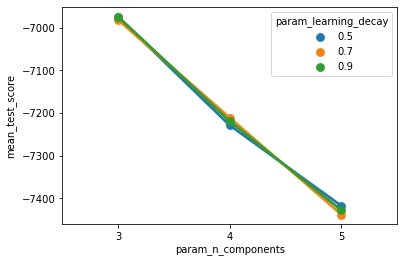

In [23]:
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

In [24]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.530000,0.440000,0.030000,0
Doc1,0.030000,0.470000,0.500000,2
Doc2,0.900000,0.050000,0.050000,0
Doc3,0.060000,0.080000,0.860000,2
Doc4,0.760000,0.180000,0.050000,0
Doc5,0.060000,0.450000,0.490000,2
Doc6,0.060000,0.050000,0.890000,2
Doc7,0.460000,0.510000,0.030000,1
Doc8,0.400000,0.060000,0.540000,2
Doc9,0.660000,0.030000,0.310000,0


In [25]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,2,296
1,0,235
2,1,214


In [26]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  39.587230
1      -387.996002  -373.316162       2        1  30.306648
0     -2184.745605   -60.565800       3        1  30.106122, topic_info=         Term        Freq       Total Category  logprob  loglift
132    potato  135.000000  135.000000  Default  30.0000  30.0000
19      breed   86.000000   86.000000  Default  29.0000  29.0000
130      pork   84.000000   84.000000  Default  28.0000  28.0000
136      rice  120.000000  120.000000  Default  27.0000  27.0000
111  mushroom   55.000000   55.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
141     salad   20.927436   84.051923   Topic3  -4.4583  -0.1899
127    pepper   19.883092   90.828249   Topic3  -4.5095  -0.3187
120      pack   18.263064   56.198753   Topic3  -4.5945   0.0764
70    flavour   18.945339   91.025430   Topic3  -4.5578  -0.3691
150     slice   16.288353   45.467314   Topic3  -4.7090   0.1739

[177 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.951333    apricot
6         1  0.969498       bake
6         2  0.023083       bake
7         3  0.951347   balsamic
9         1  0.680261       bean
...     ...       ...        ...
197       3  0.039301    vitamin
198       1  0.334978       warm
198       2  0.642042       warm
198       3  0.027915       warm
201       3  0.983630  yorkshire

[235 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [27]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,add,african,almond,alternative,apricot,aubergine,bake,balsamic,base,bean,...,use,vegetable,version,vibrant,vinegar,vitamin,warm,white,wild,yorkshire
Topic0,4.634720,6.118199,7.534441,5.715126,12.318688,8.047617,0.365761,12.289440,7.683160,0.457190,...,42.699696,0.353899,7.482474,3.122941,0.373734,2.963628,1.216395,0.411351,0.381722,43.294520
Topic1,19.630304,0.350026,0.359120,0.732927,0.345382,1.275824,1.346630,0.351731,10.740698,31.336198,...,7.933796,15.107750,0.340479,2.514537,10.195331,32.420081,23.583862,7.575229,9.380324,0.350014
Topic2,12.734976,4.531775,18.106439,5.551946,0.335929,19.676559,43.287608,0.358829,0.576141,67.206612,...,0.366507,4.538351,3.177046,10.362522,0.430936,43.616291,12.199744,6.013420,7.237954,0.355466


In [28]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,breed,pork,sauce,smoke,mushroom,spice,beef,yorkshire,use,onion,meatball,sweet,rich,steak,spring
Topic 1,rice,sauce,black,flavour,noodle,ginger,sweet,sprinkle,salmon,vitamin,crunchy,bean,rich,buckwheat,source
Topic 2,sweet,potato,bean,roast,cod,chicken,tomato,pepper,freerange,salad,vitamin,bake,source,fish,spice


In [29]:
lda_output.shape

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(745, 3)

In [30]:
data = data.set_index('id')

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
data = data.drop('ktd', axis = 1)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
X  = pd.DataFrame(data = lda_output, index = data.index, columns = ['C1','C2', 'C3'])

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
final_data = data.merge(X, left_index= True, right_index = True)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### PCA

In [34]:
pca = decomposition.PCA(n_components  = 2)
pca.fit(final_data)
final_data = pca.transform(final_data)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
#scaler = MinMaxScaler()
#final_data_sc = scaler.fit_transform(final_data)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### kmeans clustering

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


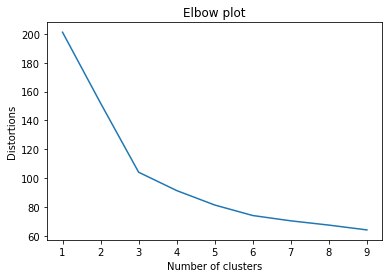

In [36]:
# Using the elbow method to find the optimal number of clusters
k = 10
distortions = []
for i in range(1, k):
    kmean_model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmean_model.fit(final_data)
    distortions.append(sum(np.min(cdist(final_data, kmean_model.cluster_centers_, 'euclidean'), axis=1)) / final_data.shape[0])
    
plt.plot(range(1, k), distortions)
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.show()

In [37]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=100)
y_kmeans = kmeans.fit_predict(final_data)


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
final_data = pd.DataFrame(final_data, index = data.index, columns =['PCA1', 'PCA2'])

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


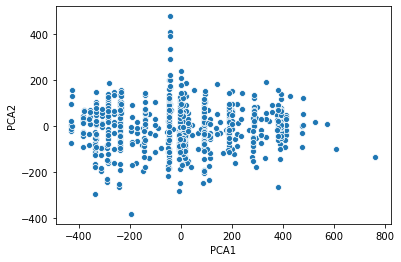

In [39]:
sns.scatterplot(x ='PCA1', y ='PCA2', data = final_data)

c:\users\g.decillis.ss-gdc\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


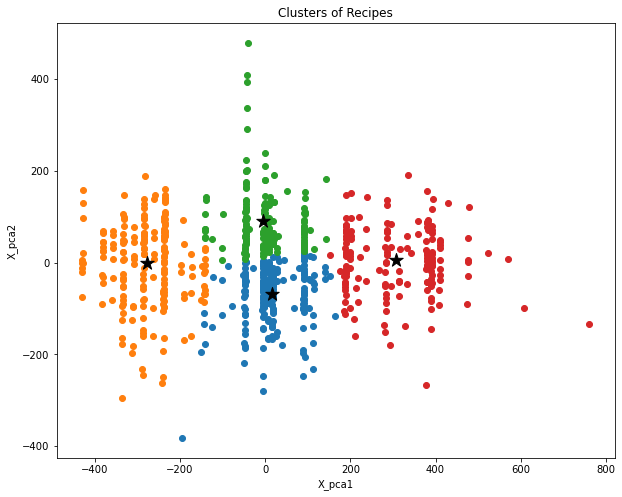

In [40]:
# Visualising the clusters
fig, ax = plt.subplots(figsize=(10,8))
x = final_data['PCA1'].values
y = final_data['PCA2'].values

plt.scatter(final_data.values[y_kmeans == 0, 0], final_data.values[y_kmeans == 0, 1])
plt.scatter(final_data.values[y_kmeans == 1, 0], final_data.values[y_kmeans == 1, 1])          
plt.scatter(final_data.values[y_kmeans == 2, 0], final_data.values[y_kmeans == 2, 1])
plt.scatter(final_data.values[y_kmeans == 3, 0], final_data.values[y_kmeans == 3, 1])

#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', label = 'Centroids', marker = '*')
plt.title('Clusters of Recipes')
plt.xlabel("X_pca1")
plt.ylabel("X_pca2")
plt.show()